In [1]:
import torch
from torchinfo import summary

import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

import torch
from torchvision import transforms

In [2]:
PATCH_SIZE = 8 # P
IMAGE_CROP = 240
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 1
BATCH_SIZE = 64
NUM_HEADS = 6
NUM_LAYERS = 2
MLP_DROPOUT = 0.1
ATTN_DROPOUT = 0.0
EMBEDDING_DROPOUT = 0.1
MLP_SIZE = 768
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
N_EPOCHS = 50
LR = 0.001

# EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2 # Hidden Size D
EMBEDDING_DIMS = 24

#the image width and image height should be divisible by patch size. This is a check to see that.
assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

Using device:  cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [3]:
train_transform = transforms.Compose([
    # transforms.CenterCrop(IMAGE_CROP),
    transforms.Resize((IMAGE_WIDTH, IMAGE_WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

from dataset import create_dataloaders
root_dir = "C:/Users/Jacqu/Downloads/AD_NC"
train_loader, valid_loader, test_loader = create_dataloaders(root_dir, train_transform, test_transform, batch_size=BATCH_SIZE, datasplit=0.8)
print(f"Num batches for train: {len(train_loader)}")
print(f"Num batches for valid: {len(valid_loader)}")

Num batches for train: 269
Num batches for valid: 68


In [4]:
from modules import *
model = ViT(
        img_size=IMAGE_WIDTH,
        in_channels = IMAGE_CHANNELS,
        patch_size = PATCH_SIZE,
        embedding_dim = EMBEDDING_DIMS,
        num_transformer_layers = NUM_LAYERS,
        mlp_dropout = MLP_DROPOUT,
        attn_dropout = ATTN_DROPOUT,
        embedding_dropout=EMBEDDING_DROPOUT,
        mlp_size = MLP_SIZE,
        num_heads = NUM_HEADS,
        num_classes = NUM_CLASSES).to(device)

summary(model=model,
        input_size=(BATCH_SIZE, IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 1, 224, 224]    [64, 2]              18,864               True
├─PatchEmbedding (patch_embedding)                           [64, 1, 224, 224]    [64, 784, 24]        --                   True
│    └─Conv2d (patcher)                                      [64, 1, 224, 224]    [64, 24, 28, 28]     1,560                True
│    └─Flatten (flatten)                                     [64, 24, 28, 28]     [64, 24, 784]        --                   --
├─Dropout (embedding_dropout)                                [64, 785, 24]        [64, 785, 24]        --                   --
├─Sequential (transformer_encoder)                           [64, 785, 24]        [64, 785, 24]        --                   True
│    └─TransformerEncoderBlock (0)                           [64, 785, 24]        [64, 785, 24] 

In [5]:
optimizer = Adam(model.parameters(), 
                lr=LR)
                # weight_decay=0.1,
                # betas=(0.9, 0.999)) # Based on the paper
criterion = CrossEntropyLoss()

In [6]:
from train import train

train_accuracies, valid_accuracies, train_losses, valid_losses = train(model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        n_epochs=N_EPOCHS)

Training: 100%|██████████| 50/50 [37:39<00:00, 45.20s/it]


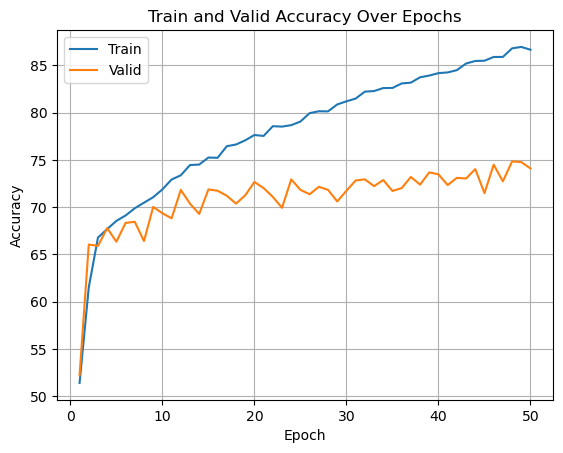

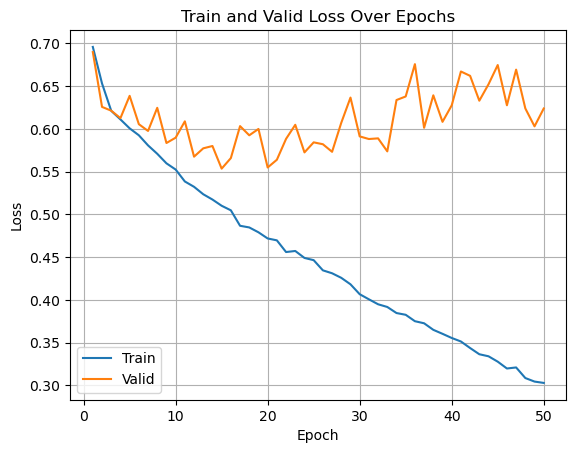

In [7]:
from utils import plot_data

plot_data(train_accuracies, valid_accuracies, labels=['Train', 'Valid'], heading='Accuracy')
plot_data(train_losses, valid_losses, labels=['Train', 'Valid'], sheading='Loss')

In [8]:
from predict import test
test(model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device)

Testing: 100%|██████████| 141/141 [00:14<00:00,  9.42it/s]

Test loss: 0.93
Test accuracy: 61.78%
